In [1]:
!pip install kaggle
api_token = {"username":"aleksandradeis","key":"cb7e1d2d7ee196c47ee7c93074933565"}
import json
import zipfile
import os

os.environ['KAGGLE_USERNAME'] = "aleksandradeis"
os.environ['KAGGLE_KEY'] = "cb7e1d2d7ee196c47ee7c93074933565"

!kaggle config path -p /content
!kaggle competitions download -c understanding_cloud_organization

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
train_images.zip: Skipping, found more recently modified local copy (use --force to force download)
test_images.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
! ls

0011165.jpg  32f591b.jpg  6566b6a.jpg  97f4fa0.jpg  ccff999.jpg
002be4f.jpg  332711f.jpg  656b784.jpg  97f678e.jpg  ccfff5f.jpg
0031ae9.jpg  332cb5c.jpg  657399d.jpg  9806f56.jpg  cd29cec.jpg
0035239.jpg  3361513.jpg  657da26.jpg  981db5b.jpg  cd3ad22.jpg
003994e.jpg  336c1c1.jpg  659c0e7.jpg  982e404.jpg  cd40ced.jpg
00498ec.jpg  338508c.jpg  65b6bf1.jpg  983adc5.jpg  cd506f6.jpg
006bf7c.jpg  33853a8.jpg  65bd57f.jpg  983d323.jpg  cd564f5.jpg
006c5a6.jpg  338b26d.jpg  65c7db7.jpg  983f3f7.jpg  cd617d7.jpg
008233e.jpg  33a5c0d.jpg  65c8f29.jpg  984c799.jpg  cd6b11d.jpg
008a5ff.jpg  33accb4.jpg  65d0637.jpg  985cea4.jpg  cd6b401.jpg
0091591.jpg  33b39e2.jpg  65d4ea5.jpg  985d5aa.jpg  cd785d7.jpg
0095357.jpg  33bb572.jpg  65d517a.jpg  985e112.jpg  cd807f8.jpg
009e2f3.jpg  33bf913.jpg  65e3251.jpg  986602e.jpg  cd83e4b.jpg
00a0954.jpg  33ccc99.jpg  65e4b8e.jpg  98682ba.jpg  cd85660.jpg
00b81e1.jpg  33cdcc4.jpg  660321e.jpg  9871dc7.jpg  cd97abb.jpg
00bea06.jpg  33d4a84.jpg  660f86e.jpg  9

In [3]:
! unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
! unzip train_images.zip

Archive:  train_images.zip
replace 81de6b7.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
! pip install albumentations

In [0]:
from __future__ import print_function, division, absolute_import

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import OrderedDict

# import data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import image utils
import PIL
from PIL import Image, ImageOps, ImageEnhance

# import image processing
import scipy.ndimage as ndi
import scipy

# import image utilities
from skimage.morphology import binary_opening, disk, label, binary_closing

# import image augmentation
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, PadIfNeeded, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform,
    NoOp, RandomSizedCrop, RGBShift, VerticalFlip, RandomRotate90
)

# Import PyTorch
import torch
from torch import nn
from torch import optim
from torch.optim import Optimizer
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.autograd import Variable
import torch.utils.model_zoo as model_zoo
from torch.nn import init
from torch.optim import lr_scheduler

import math
import os

import time

from tqdm import tqdm_notebook

import cv2

from skimage.morphology import binary_opening, disk, label

In [0]:
TRAIN_PATH = './'
TEST_PATH = './'

train = pd.read_csv('train.csv')

#train_transforms = Compose([HorizontalFlip(p=0.5),
#                            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.2)])

train_transforms = Compose([
    OneOf([
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                         rotate_limit=15,
                         border_mode=cv2.BORDER_CONSTANT),
        OpticalDistortion(distort_limit=0.11, shift_limit=0.15,
                          border_mode=cv2.BORDER_CONSTANT),
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        NoOp()]),
    RandomSizedCrop(min_max_height=(1050, 1400),
                    height=1400,
                    width=2100, p=0.3),
    RandomRotate90(p=0.5),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5)
])

In [3]:
# split column
split_df = train["Image_Label"].str.split("_", n = 1, expand = True)
# add new columns to train_df
train['Image'] = split_df[0]
train['Label'] = split_df[1]
# fiil missing masks with '-1'
train = train.fillna('-1')

# check the result
train.head()

,Image_Label,EncodedPixels,Image,Label
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,0011165.jpg_Gravel,-1,0011165.jpg,Gravel
3,0011165.jpg_Sugar,-1,0011165.jpg,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


In [0]:
def rle_to_mask(rle_string, height, width):
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

In [0]:
class CloudDataset(Dataset):
    def __init__(self, dataset_path, df, transforms=None, size = (256, 256), mode = 'train'):
        self.dataset_path = dataset_path
        self.df = df
        self.transforms = transforms
        self.size = size
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # open image and label
        id_code = self.df.loc[idx]['Image']
        image = Image.open(os.path.join(self.dataset_path, str(id_code)))
        
        if self.mode == 'train' or self.mode == 'test':
            rle_mask = self.df.loc[idx]['EncodedPixels']
            if rle_mask == '-1':
                np_mask = np.zeros(self.size)
            else:
                np_mask = rle_to_mask(rle_mask, image.size[1], image.size[0])
        else:
            np_mask = np.zeros(self.size)
        
        # augment image and mask
        if self.transforms != None:
            if (rle_mask) == '-1':
                augmented = self.transforms(image=np.array(image))
            else:
                augmented = self.transforms(image=np.array(image), mask = np_mask)
                np_mask = augmented['mask']
            image = Image.fromarray(augmented['image'], 'RGB')
        
        # normalize and convert to tensor
        tf = transforms.Compose([transforms.Resize(self.size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        image = tf(image)
        
        if (rle_mask) != "-1":
            tf = transforms.Compose([transforms.Resize(self.size),
                                 transforms.ToTensor()])
            mask = Image.fromarray(np_mask, 'L')
            mask = tf(mask).float()
        else:
            mask = TF.to_tensor(np_mask).float()
        
        # in validation mode return image and id_code
        if self.mode == 'validation':
            return image, id_code

        # return tensor with image and label
        return image, mask

In [0]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

def one_hot_embedding(labels, num_classes):
    '''Embedding labels to one-hot form.
    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.
    Returns:
      (tensor) encoded labels, sized [N,#classes].
    '''
    y = torch.eye(num_classes)  # [D,D]
    return y[labels]            # [N,D]

class FocalLoss(nn.Module):
    def __init__(self, num_classes=20):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes

    def focal_loss(self, x, y):
        '''Focal loss.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        gamma = 2

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)  # [N,21]
        t = t[:,1:]  # exclude background
        t = Variable(t).cuda()  # [N,20]

        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

    def focal_loss_alt(self, x, y):
        '''Focal loss alternative.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)
        t = t[:,1:]
        t = Variable(t).cuda()

        xt = x*(2*t-1)  # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        '''Compute loss between (loc_preds, loc_targets) and (cls_preds, cls_targets).
        Args:
          loc_preds: (tensor) predicted locations, sized [batch_size, #anchors, 4].
          loc_targets: (tensor) encoded target locations, sized [batch_size, #anchors, 4].
          cls_preds: (tensor) predicted class confidences, sized [batch_size, #anchors, #classes].
          cls_targets: (tensor) encoded target labels, sized [batch_size, #anchors].
        loss:
          (tensor) loss = SmoothL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets).
        '''
        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0  # [N,#anchors]
        num_pos = pos.data.long().sum()

        ################################################################
        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        ################################################################
        mask = pos.unsqueeze(2).expand_as(loc_preds)       # [N,#anchors,4]
        masked_loc_preds = loc_preds[mask].view(-1,4)      # [#pos,4]
        masked_loc_targets = loc_targets[mask].view(-1,4)  # [#pos,4]
        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, size_average=False)

        ################################################################
        # cls_loss = FocalLoss(loc_preds, loc_targets)
        ################################################################
        pos_neg = cls_targets > -1  # exclude ignored anchors
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1,self.num_classes)
        cls_loss = self.focal_loss_alt(masked_cls_preds, cls_targets[pos_neg])

        print('loc_loss: %.3f | cls_loss: %.3f' % (loc_loss.data[0]/num_pos, cls_loss.data[0]/num_pos), end=' | ')
        loss = (loc_loss+cls_loss)/num_pos
        return loss

In [0]:
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)

Source:
https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py
"""

from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / float(union))
        ious.append(iou)
    ious = [mean(iou) for iou in zip(*ious)] # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------

class LovaszSoftmaxLoss(nn.Module):
    """
    Class wrapper for lovasz_softmax loss function.
    """
    def __init__(self):
        super(LovaszSoftmaxLoss, self).__init__()

    def forward(self, input, target):
        return lovasz_softmax(input, target, classes=[1])

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    if probas.dim() == 3:
        # assumes output of a sigmoid layer
        B, H, W = probas.size()
        probas = probas.view(B, 1, H, W)
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x


def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n


In [0]:
def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

In [0]:
def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

In [0]:
'''
Source:
https://github.com/ternaus/TernausNet
'''

# Import PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_filters=32, pretrained=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with VGG11
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.vgg11(pretrained=pretrained).features

        self.relu = self.encoder[1]
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return self.final(dec1)


def unet11(pretrained=False, **kwargs):
    """
    pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with VGG11
            carvana - all weights are pre-trained on
                Kaggle: Carvana dataset https://www.kaggle.com/c/carvana-image-masking-challenge
    """
    model = UNet11(pretrained=pretrained, **kwargs)
    return model


class Interpolate(nn.Module):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners

    def forward(self, x):
        x = self.interp(x, size=self.size, scale_factor=self.scale_factor,
                        mode=self.mode, align_corners=self.align_corners)
        return x


class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                Interpolate(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class AlbuNet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder
        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)

        return x_out


class UNet16(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network used
            True - encoder pre-trained with VGG16
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out

In [0]:
model = UNet16(pretrained = True)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [0]:
# define hyperparameters
test_split = 0.2
batch_size = 16
epochs = 1
learning_rate = 0.001
num_workers = 1
image_size = 224

In [0]:
# create dataset and data loaders (for FISH)
df = train[train['Label'] == 'Fish']
df = df.set_index(pd.Series(range(len(df))))

train_ds = CloudDataset(TRAIN_PATH, df, 
                        transforms=train_transforms, size = (image_size, image_size), mode = 'train')
test_ds = CloudDataset(TRAIN_PATH, df, 
                       transforms=None, size = (image_size, image_size), mode = 'test')

dataset_size = len(train_ds)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

In [0]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [0]:
optimizer = RAdam(model.parameters(), lr=learning_rate)

train_stats = pd.DataFrame(columns = ['Epoch', 
                                      'Time per epoch', 
                                      'Avg time per step', 
                                      'Train loss',
                                      'DICE Train',
                                      'Test loss',
                                     'DICE Test']) 
criterion = LovaszSoftmaxLoss()

In [0]:
def train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats):
    #train the model
    model.to(device)
    
    # learning rate scheduler
    
    #scheduler = lr_scheduler.CosineAnnealingLR(optimizer, len(trainloader), eta_min=0.000001)
    #StepLR, ReduceLROnPlateau, CosineAnnealingLR
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.15, patience=2)

    steps = 0
    running_loss = 0
    dice_train = 0
    for epoch in range(epochs):

        since = time.time()

        train_accuracy = 0
        dice_train = 0
        iou_train = 0
        
        for inputs, labels in tqdm_notebook(trainloader):
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            
            loss = criterion(logps, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            dice_train += dice_coef(logps, labels)
            
            #iou_train += iou_score(logps, labels)

        time_elapsed = time.time() - since

        test_loss = 0
        dice_test = 0
        iou_test = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()

                # Calculate DICE
                dice_test += dice_coef(logps, labels)
                
                #iou_test += iou_score(logps, labels)

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Time per epoch: {time_elapsed:.4f}.. "
              f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
              f"Train loss: {running_loss/len(trainloader):.4f}.. "
              f"Test loss: {test_loss/len(testloader):.4f}.. "
              f"DICE Train: {dice_train/len(trainloader):.4f}.. "
              f"DICE Test: {dice_test/len(testloader):.4f}.. "
              #f"IOU Train: {iou_train/len(trainloader):.4f}.. "
              #f"IOU Test: {iou_test/len(testloader):.4f}.. "
             )

        train_stats = train_stats.append({'Epoch': epoch + 1, 
                                          'Time per epoch':time_elapsed, 
                                          'Avg time per step': time_elapsed/len(trainloader), 
                                          'Train loss' : running_loss/len(trainloader),
                                          'Test loss' : test_loss/len(testloader),
                                          'DICE Train' : dice_train/len(trainloader),
                                          'DICE Test' : dice_test/len(testloader),
                                         }, 
                                         ignore_index=True)
                
        scheduler.step(test_loss/len(testloader))
        running_loss = 0
        model.train()
        
    return model, train_stats

In [19]:
# train the model
model, train_stats = train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats)


Epoch 1/1.. Time per epoch: 1130.0366.. Average time per step: 4.0649.. Train loss: 0.5718.. Test loss: 0.5180.. DICE Train: 0.2430.. DICE Test: 0.2437.. 


In [0]:
filename = 'vggunet_' + str(epochs) + '.pth'

checkpoint = {'state_dict': model.state_dict()}

torch.save(checkpoint, filename)

In [0]:
# save training stats
train_stats.to_csv('vggunet_stats.csv', index=False)

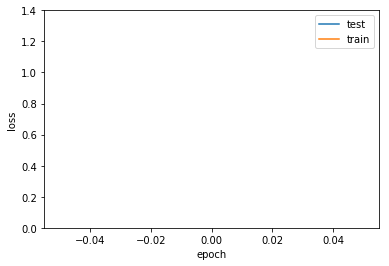

In [23]:
plt.plot(train_stats['Test loss'], label="test")
plt.plot(train_stats['Train loss'], label="train")
plt.ylim(0, 1.4)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc='best')
run.log_image("loss", plt)

plt.show()

In [0]:
plt.plot(train_stats['DICE Train'], label="test")
plt.plot(train_stats['DICE Test'], label="train")
plt.ylim(0, 1)
plt.xlabel("epoch")
plt.ylabel("dice")
plt.legend(loc='best')
run.log_image("dice", plt)

plt.show()

In [0]:

test_loss = 0
dice_test = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()

        # Calculate DICE
        dice_test += dice_coef(logps, labels)
        
test_loss = test_loss / len(testloader)
dice_test = dice_test / len(testloader)

In [25]:
print('Test loss: {}'.format(test_loss))
print('DICE test: {}'.format(dice_test))

Test loss: 0.5175957713808332
DICE test: 0.24655391968638868


In [0]:
def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

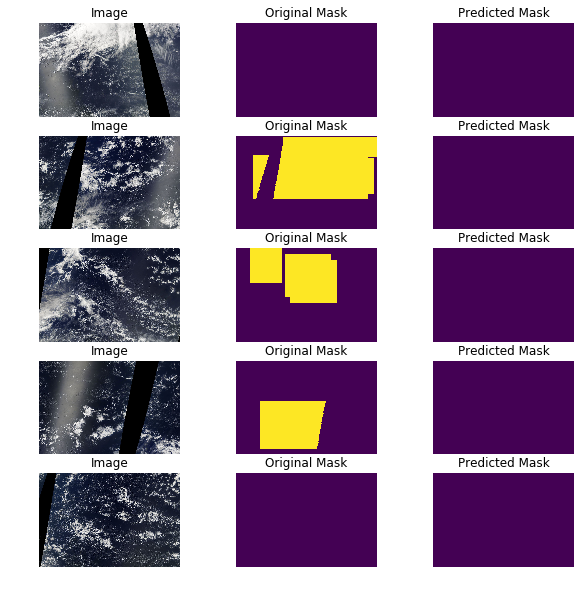

In [27]:
im_width = image_size
im_height = image_size

orig_width = 2100
orig_height = 1400

threshold = 0.3

n_images = 5
fig, ax = plt.subplots(n_images, 3, figsize=(10, 10))

indices = [np.random.choice(test_indices) for i in range(n_images)]

model.eval()
c = 0
with torch.no_grad():
    for idx in indices:
        
        id_code = df.loc[idx]['Image']
        image = Image.open(os.path.join(TRAIN_PATH, str(id_code)))
    
        tf = transforms.Compose([transforms.Resize((im_width,im_height)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        inputs = tf(image)
        inputs = inputs.to(device)

        output = model.forward(inputs.reshape(1,3,image_size,image_size))

        pred_mask = torch.sigmoid(output.reshape(im_width,im_height)).data.cpu().numpy()
        pred_mask = binary_opening(pred_mask > threshold, disk(2))

        pred_mask = Image.fromarray((pred_mask * 255).astype(np.uint8)).resize((orig_width,orig_height))
        
        rle_mask = df.loc[idx]['EncodedPixels']
        if rle_mask == '-1':
            np_mask = np.zeros((orig_height, orig_width))
        else:
            np_mask = rle_to_mask(rle_mask, orig_height, orig_width)
            
        # plot images and masks
        ax[c, 0].imshow(image)
        ax[c, 0].axis('off')
        ax[c, 0].set_title('Image')
        
        # plot images and masks
        ax[c, 1].imshow(np_mask)
        ax[c, 1].axis('off')
        ax[c, 1].set_title('Original Mask')
        
        # plot images and masks
        ax[c, 2].imshow(pred_mask)
        ax[c, 2].axis('off')
        ax[c, 2].set_title('Predicted Mask')
        
        c+=1
        
plt.show()